# 1. Problemin Tanımı
Bu çalışma, bir şirketin geçmiş hisse fiyat verilerini veya kurun kullanarak gelecekteki fiyatını tahmin etmeyi amaçlar. LSTM tabanlı bir model kullanılacaktır.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (16, 9)

ModuleNotFoundError: No module named 'tensorflow'

# 2. Veri Yükleme ve İnceleme (EDA)

İlk 5 Satır:
  Date   Adj Close       Close        High         Low        Open    Volume
0  NaT  132.630005  132.630005  134.750000  132.330002  134.645004  15427791
1  NaT  132.024994  132.024994  132.639893  131.454895  132.619995  11396429
2  NaT  132.648804  132.648804  133.000000  131.740005  132.020004   7998924
3  NaT  132.645294  132.645294  133.250000  132.509995  132.648895   6476131
4  NaT  132.029999  132.029999  132.690002  132.009995  132.639999   6082332

Veri Boyutu: (3465, 7)

Veri Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3465 entries, 0 to 3464
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       0 non-null      datetime64[ns]
 1   Adj Close  3465 non-null   float64       
 2   Close      3465 non-null   float64       
 3   High       3465 non-null   float64       
 4   Low        3465 non-null   float64       
 5   Open       3465 non-null   float64       
 6  

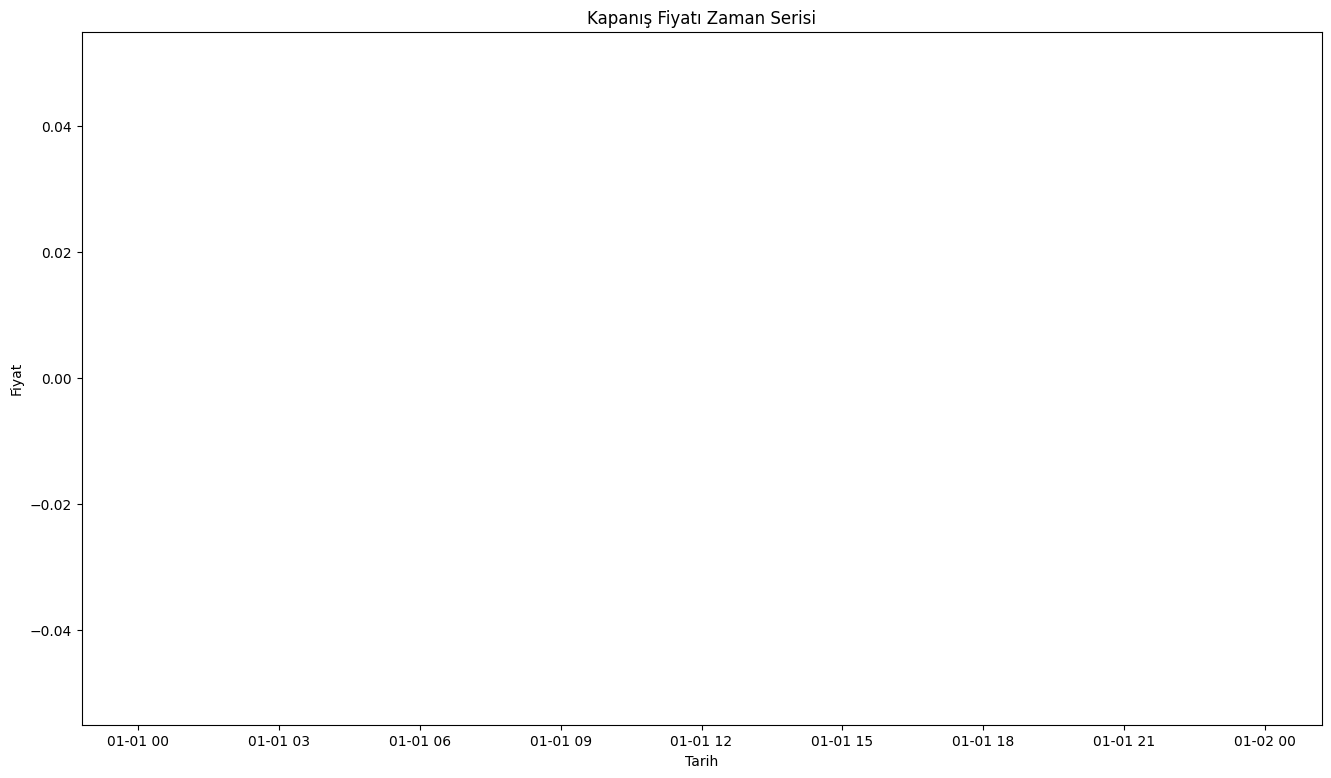


İstatistiksel Özellikler:
count    3465.000000
mean      187.028862
std        27.019410
min       124.570000
25%       171.145004
50%       183.729996
75%       208.858994
max       250.440002
Name: Close, dtype: float64


In [2]:
file_path = 'APPLE_stock_data.csv'  # Dosya yolunuzu belirtin.
df = pd.read_csv(file_path)

# Tarihi datetime formata çevir
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')

# Tarihe göre sırala
df = df.sort_values('Date', ascending=True).reset_index(drop=True)

# Veri önizleme
print("İlk 5 Satır:")
print(df.head())
print("\nVeri Boyutu:", df.shape)
print("\nVeri Bilgisi:")
print(df.info())
print("\nEksik Veri Sayısı:")
print(df.isnull().sum())

# Fiyat zaman serisi grafiği
plt.title("Kapanış Fiyatı Zaman Serisi")
plt.plot(df['Date'], df['Close'])
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.show()

print("\nİstatistiksel Özellikler:")
print(df['Close'].describe())

# 3. Ön İşleme (Data Preprocessing)
Eksik değer yok varsayımıyla devam ediyoruz.
Sadece 'Close' sütununu kullanacağız.

In [3]:
for i in range(1, len(df['Close']) - 1):
    if np.isnan(df['Close'][i]):
        df.loc[i, 'Close'] = np.nanmean([df['Close'][i - 1], df['Close'][i + 1]])

fiyat = df['Close'].values.reshape(-1, 1)

# 4. Feature Engineering (Özellik Mühendisliği)
Ekstra özellik eklemiyoruz.

In [4]:
# Ölçeklendirme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(fiyat)

def dataset_olustur(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100

# 5. Eğitim-Test Ayrımı (Train-Test Split)

In [5]:
train_size = int(len(scaled_prices) * 0.8)
test_size = len(scaled_prices) - train_size
train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:]

X_train, y_train = dataset_olustur(train_data, time_step)
X_test, y_test = dataset_olustur(test_data, time_step)

# LSTM girişi 3 boyutlu: [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Eğitim veri boyutu:", X_train.shape, y_train.shape)
print("Test veri boyutu:", X_test.shape, y_test.shape)

Eğitim veri boyutu: (2671, 100, 1) (2671,)
Test veri boyutu: (592, 100, 1) (592,)


# 6. Model Kurulumu

In [6]:
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1))))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = create_model()

c:\Users\ylmz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 7. Model Eğitimi ve Doğrulaması (Validation)
EarlyStopping ile durdurma. Burada patience=5 kullanıyoruz.

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0099 - val_loss: 0.0141
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - loss: 0.0226 - val_loss: 0.0019
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0088 - val_loss: 0.0034


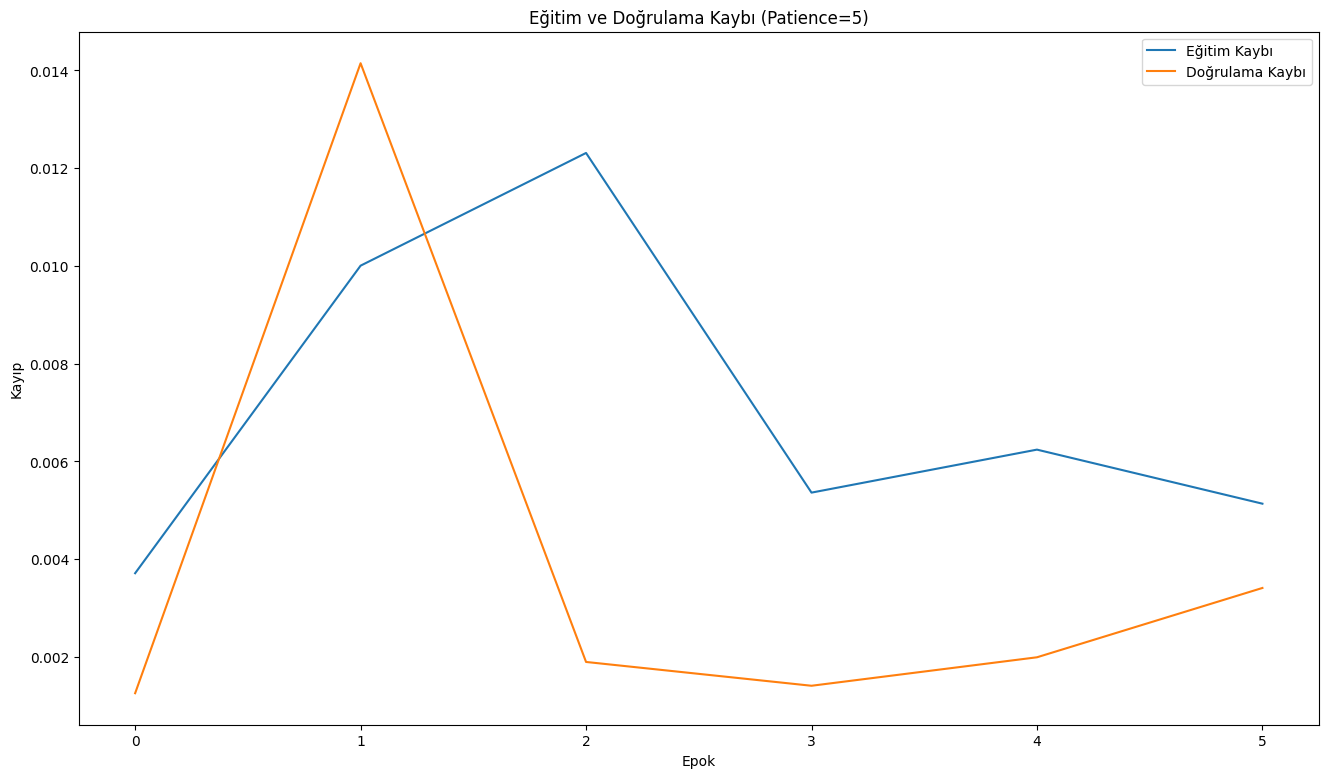

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train, 
    epochs=100,
    batch_size=64, 
    validation_data=(X_test, y_test), 
    shuffle=False, 
    callbacks=[early_stop],
    verbose=1
)

# Eğitim sürecinin kaybı
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı (Patience=5)')
plt.xlabel('Epok')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# 8. Değerlendirme (Evaluation)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


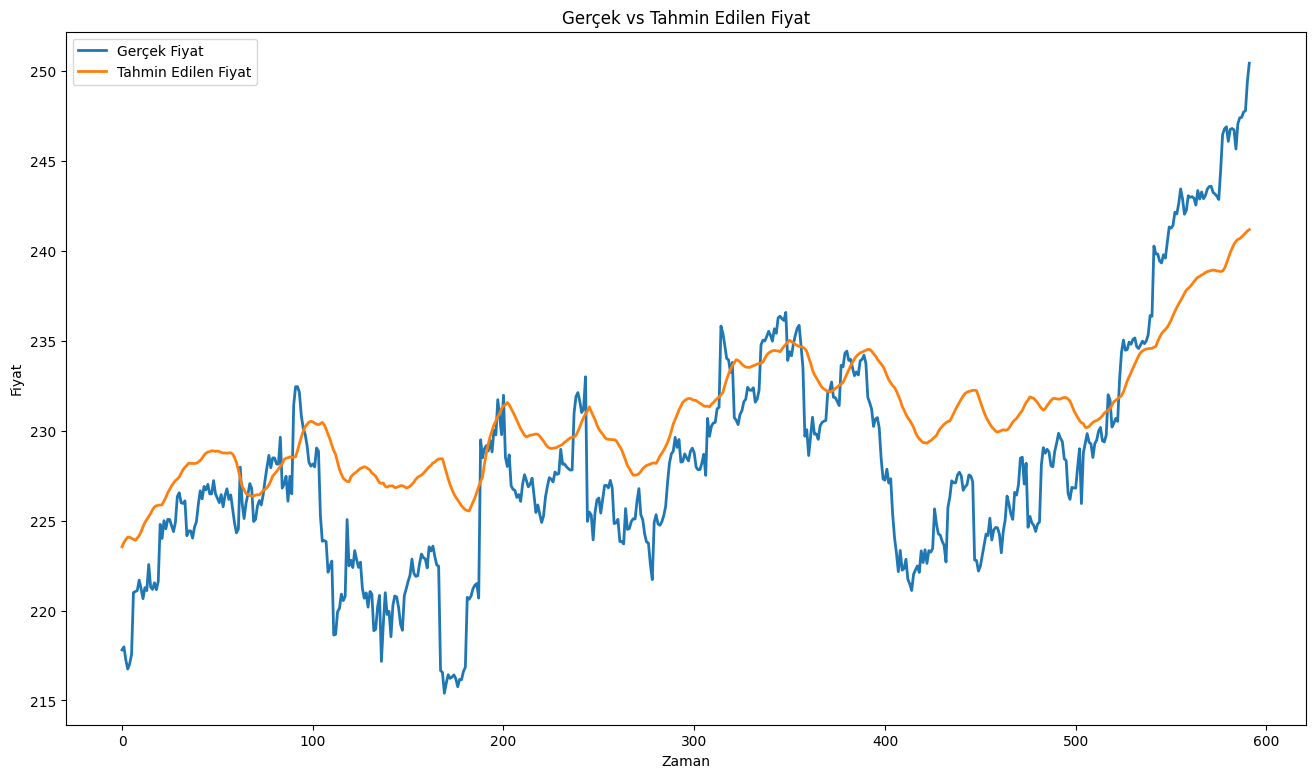

MAE: 3.750171017002415
RMSE: 4.5322508493773075
MAPE: 1.6559849333524272 %


In [8]:
fiyat_tahmini = model.predict(X_test)
fiyat_tahmini = scaler.inverse_transform(fiyat_tahmini)
gercek_fiyat = scaler.inverse_transform(test_data[time_step+1:])

plt.plot(gercek_fiyat, label='Gerçek Fiyat', linewidth=2)
plt.plot(fiyat_tahmini, label='Tahmin Edilen Fiyat', linewidth=2)
plt.title('Gerçek vs Tahmin Edilen Fiyat')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

mae = mean_absolute_error(gercek_fiyat, fiyat_tahmini)
mse = mean_squared_error(gercek_fiyat, fiyat_tahmini)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((gercek_fiyat - fiyat_tahmini) / gercek_fiyat)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape, "%")

# 9. Gelecek Tahminleri (Deployment/Future Predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

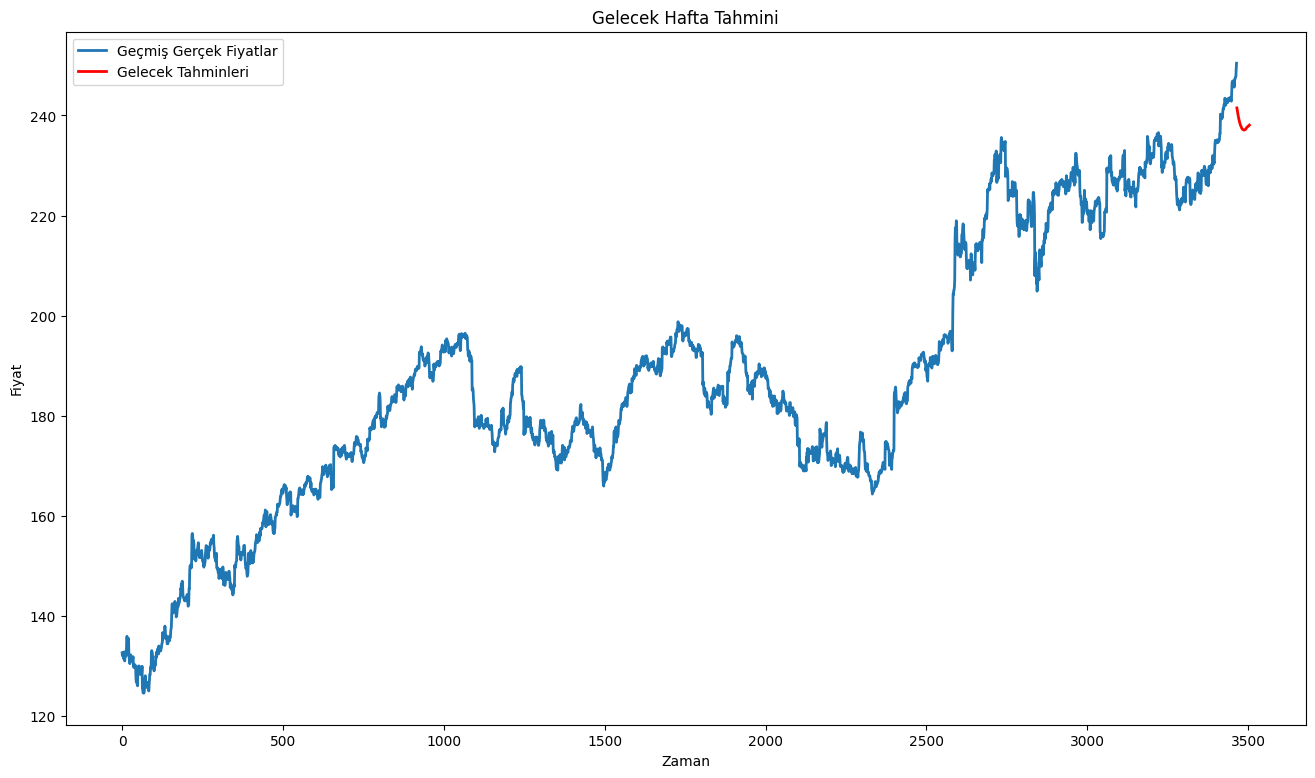

Sonraki 40 adım tahminleri: [241.50926 241.15678 240.76411 240.37123 239.98534 239.64871 239.33908
 239.04419 238.77927 238.54156 238.31108 238.09727 237.96046 237.79169
 237.63411 237.48933 237.37595 237.28682 237.2296  237.17548 237.13425
 237.10165 237.08594 237.10194 237.13345 237.16782 237.17859 237.218
 237.3048  237.40474 237.51305 237.6273  237.6991  237.7462  237.78642
 237.8412  237.89864 237.95308 238.01501 238.07967]


In [9]:
# Son 100 zaman dilimini kullanarak tahminleri yapalım
son_girdi = scaled_prices[-time_step:]  # Son 100 veriyi alıyoruz
tahminler = []

# 40 adım tahmini yapıyoruz
for _ in range(40):
    tahmin = model.predict(son_girdi.reshape(1, time_step, 1))  # Model tahmin yapıyor
    tahminler.append(tahmin[0, 0])  # Tahmin edilen değeri listeye ekliyoruz
    #son_girdi = np.append(son_girdi[1:], tahmin, axis=0)  # Yeni tahmini son girdiye ekliyoruz
    son_girdi = np.concatenate([son_girdi[1:], tahmin], axis=0)
    
# Tahmin edilen değerleri orijinal ölçeğe geri çevir
tahmin_edilen_degerler = scaler.inverse_transform(np.array(tahminler).reshape(-1, 1))
orijinal_fiyatlar = scaler.inverse_transform(scaled_prices)

# Gelecek adımlar için x eksenini belirleyelim
gelecek_adimlar = list(range(len(orijinal_fiyatlar), len(orijinal_fiyatlar) + 40))

# Gerçek ve tahmin edilen fiyatları görselleştirelim
plt.plot(orijinal_fiyatlar, label='Geçmiş Gerçek Fiyatlar', linewidth=2)
plt.plot(gelecek_adimlar, tahmin_edilen_degerler, label='Gelecek Tahminleri', color='red', linewidth=2)
plt.title('Gelecek Hafta Tahmini')
plt.xlabel('Zaman')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

# Tahmin edilen gelecek fiyatları
print("Sonraki 40 adım tahminleri:", tahmin_edilen_degerler.flatten())
